In [5]:
celltype_to_corefiles = {
    'HepG2': {
        'modeljson': '/users/eprakash/projects/benchmarking/newdata/HepG2/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_ppZZI_modelJson.json',
        'modelweights': '/users/eprakash/projects/benchmarking/newdata/HepG2/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_ppZZI_modelWeights.h5',
        'valid_positive_set': '/users/eprakash/projects/benchmarking/newdata/HepG2/HepG2.summits.400bp.implanted.valid.bed.gz',
        'valid_negative_set': '/users/eprakash/projects/benchmarking/newdata/HepG2/no_HepG2_universal_dnase.matched.valid.bed.gz'
    },
    'A549': {
        'modeljson': '/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_ugaHs_modelJson.json',
        'modelweights': '/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_ugaHs_modelWeights.h5',
        'valid_positive_set': '/users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.implanted.valid.bed.gz',
        'valid_negative_set': '/users/eprakash/projects/benchmarking/newdata/A549/no_A549_universal_dnase.matched.valid.bed.gz'
    },
    'H1ESC': {
        'modeljson': '/users/eprakash/projects/benchmarking/newdata/H1ESC/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_rjU3H_modelJson.json',
        'modelweights': '/users/eprakash/projects/benchmarking/newdata/H1ESC/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_rjU3H_modelWeights.h5',
        'valid_positive_set': '/users/eprakash/projects/benchmarking/newdata/H1ESC/H1ESC.summits.400bp.implanted.valid.bed.gz',
        'valid_negative_set': '/users/eprakash/projects/benchmarking/newdata/H1ESC/no_H1ESC_universal_dnase.matched.valid.bed.gz'
    },
    'K562': {
        'modeljson': '/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/oldmodels/record_4_model_4W8mu_modelJson.json',
        'modelweights': '/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/oldmodels/record_4_model_4W8mu_modelWeights.h5',
        'valid_positive_set': '/users/eprakash/projects/benchmarking/newdata/deepsea_K562/K562.pos.summits.valid.implanted.bed.gz',
        'valid_negative_set': '/users/eprakash/projects/benchmarking/newdata/deepsea_K562/K562.neg.summits.valid.implanted.bed.gz'
    }
}

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [13]:
import keras
import numpy as np
import gzip


def onehot_encode(seqs):
    ltr = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], 'N': [0,0,0,0]}
    return np.array([[ltr[x] for x in seq.upper()] for seq in seqs])


def load_seqs_and_onehot(sequences_file):
    seqids = []
    seqs = []
    for line in gzip.open(sequences_file):
        seqid, seq = line.decode("utf-8").rstrip().split("\t")
        seqids.append(seqid)
        seqs.append(seq)
    onehotseqs = onehot_encode(seqs)
    return seqids, seqs, onehotseqs


celltypes = ['HepG2', 'A549', 'H1ESC']

celltype_to_pospreds = {}
celltype_to_negpreds = {}
celltype_to_zeropred = {}
celltype_to_avgpospred = {}
for celltype in celltypes:
    print("On",celltype)
    corefiles = celltype_to_corefiles[celltype]
    model = keras.models.model_from_json(open(corefiles['modeljson']).read())
    model.load_weights(corefiles['modelweights'])
    logit_model = keras.models.Model(inputs=model.input,
                                     outputs=model.layers[-2].output)
    (pos_seqids, pos_seqs, pos_onehotseqs) = (
        load_seqs_and_onehot(sequences_file=corefiles['valid_positive_set']))
    (neg_seqids, neg_seqs, neg_onehotseqs) = (
        load_seqs_and_onehot(sequences_file=corefiles['valid_negative_set']))
    preds_on_positives = np.squeeze(logit_model.predict(pos_onehotseqs))
    preds_on_negatives = np.squeeze(logit_model.predict(neg_onehotseqs))
    celltype_to_pospreds[celltype] = preds_on_positives
    celltype_to_negpreds[celltype] = preds_on_negatives
    celltype_to_zeropred[celltype] = logit_model.predict(
        np.zeros_like(pos_onehotseqs[0][None,:,:])).squeeze()
    celltype_to_avgpospred[celltype] = logit_model.predict(
        (np.mean(pos_onehotseqs, axis=(0,1))[None,:]
         *np.ones_like(pos_onehotseqs[0]))[None,:,:]).squeeze()

On HepG2
On A549
On H1ESC


HepG2


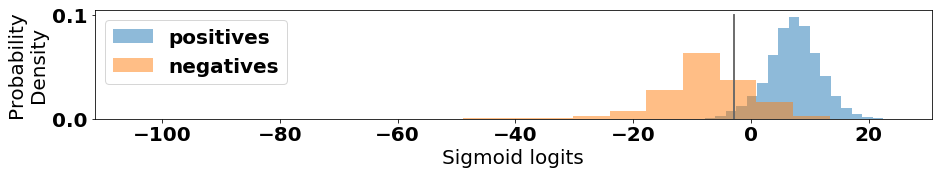

A549


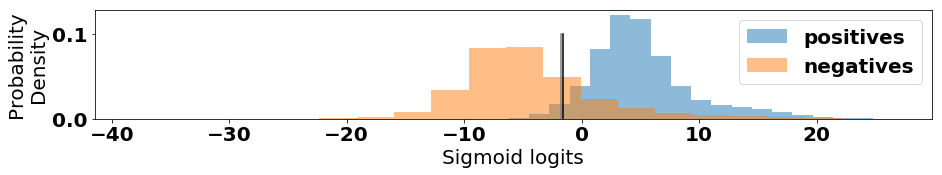

H1ESC


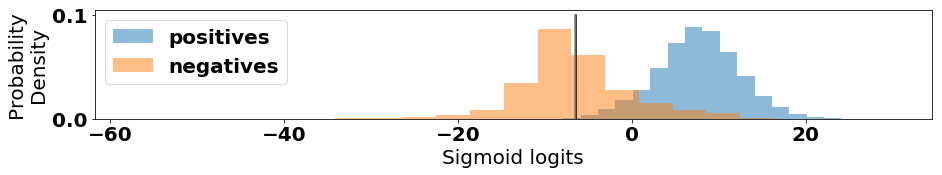

In [32]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

for celltype in celltypes:
    print(celltype)
    handles = []
    plt.figure(figsize=(15,2))
    handles.append(plt.hist(celltype_to_pospreds[celltype], alpha=0.5, bins=20, density=True))
    handles.append(plt.hist(celltype_to_negpreds[celltype], alpha=0.5, bins=20, density=True))
    plt.legend(handles, labels=["positives", "negatives"])
    plt.plot([celltype_to_zeropred[celltype], celltype_to_zeropred[celltype]], [0,0.1],
             color="black")
    plt.plot([celltype_to_avgpospred[celltype], celltype_to_avgpospred[celltype]], [0,0.1],
             color="grey")
    plt.xlabel("Sigmoid logits")
    plt.ylabel("Probability\nDensity")
    plt.show()